<a href="https://colab.research.google.com/github/basselkassem/covid19/blob/master/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
access_token = {"username":"","key":""}
with open('/content/kaggle.json', 'w') as file:
    json.dump(access_token, file)
!pip install -q kaggle
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c covid19-global-forecasting-week-4

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

mpl.rcParams['axes.grid']=True
plt.rcParams.update({'figure.figsize':(8, 5), 'figure.dpi':120})

mpl.rcParams['axes.grid']=True
pd.options.display.max_rows = 999

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
def fill_province(row):
  if pd.isna(row['Province_State']):
    row['Province_State'] = '_PROVINCE_' + row['Country_Region']
  return row

train = train.apply(fill_province, axis = 1)
test = test.apply(fill_province, axis = 1)

# Feature engineering

In [0]:
def extract_time_features(df):
  df['Day'] = df['Date'].dt.day
  df['Day_of_Week'] = df['Date'].dt.dayofweek
  df['Day_of_Year'] = df['Date'].dt.dayofyear
  df['Week_of_Year'] = df['Date'].dt.weekofyear
  df['Days_im_Month'] = df['Date'].dt.days_in_month

extract_time_features(train)
extract_time_features(test)

In [6]:
train_col_to_delete = ['Id', 'ConfirmedCases', 'Fatalities', 'Country_Region', 'Province_State', 'Date' ]
test_col_to_delete = ['ForecastId', 'Date', 'Country_Region', 'Province_State']
validation_duration = 2
validation_duration = np.timedelta64(validation_duration - 1, 'D')
print(validation_duration)

1 days


In [0]:
def train_val_split(df, display = False):
  split_thr = df['Date'].max() - validation_duration 
  df_train = df[df['Date'] < split_thr ]
  X_train = df_train.drop(columns = train_col_to_delete)
  y_cc_train = df_train[['ConfirmedCases']]
  y_fa_train = df_train[['Fatalities']]

  df_val= df[df['Date'] >= split_thr ]
  X_val = df_val.drop(columns = train_col_to_delete)
  y_cc_val = df_val[['ConfirmedCases']]
  y_fa_val = df_val[['Fatalities']]

  if display:
    print('data shape:', df.shape)
    print('train shape:', df_train.shape)
    print('val shape:', df_val.shape)
  return(X_train, y_cc_train, y_fa_train, X_val, y_cc_val, y_fa_val)

def plot_feature_importance(model, X):
    feat_importance = pd.DataFrame(sorted(zip(model.feature_importance(importance_type = 'gain'), X.columns)), columns=['Score','Feature'])
    feat_importance = feat_importance.sort_values(by = "Score", ascending = False)
    plt.figure(figsize = (8, 8))
    sns.barplot(x = "Score", y = "Feature", data = feat_importance)
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()
    return feat_importance.reset_index(drop = True)

def create_model(X_train, y_train, X_val, y_val, draw_metics = False):
  n_estimators = 100
  params = {
  'metric': 'rmse',
  'objective': 'mse',
  'verbose': 0, 
  'learning_rate': 0.99,
  }
  d_train = lgb.Dataset(X_train, y_train)
  d_valid = lgb.Dataset(X_val, y_val)
  watchlist = [d_train, d_valid]
  evals_result = {}
  model = lgb.train(params,
                    d_train, 
                    n_estimators,
                    valid_sets = watchlist, 
                    evals_result = evals_result, 
                    early_stopping_rounds = 10,
                    verbose_eval = 0,
                    )
  if draw_metics:
    lgb.plot_metric(evals_result) 
  return model

def rmse(y, y_hat):
    return np.sqrt(mean_squared_error(y, y_hat))

def rmsle(y, y_hat):
  y_hat = np.where(y_hat < 0, 0, y_hat)
  return 'rmsle', np.sqrt(mean_squared_log_error(y, y_hat))

def evaluate_model(model, X_train, y_train, X_val, y_val): 
    y_hat = model.predict(X_train)
    print('Training error;', rmsle(y_train, y_hat))
    y_val_hat = model.predict(X_val)
    print('Validation error:', rmsle(y_val, y_val_hat))


# Modeling for One country

data shape: (81, 11)
train shape: (79, 11)
val shape: (2, 11)


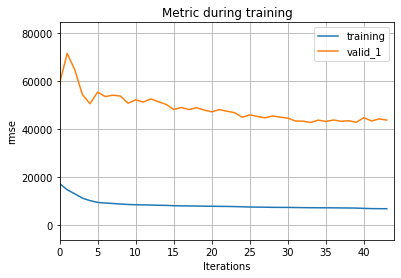

In [8]:
country = 'Germany'
province = '_PROVINCE_' + country
country_df = train[(train['Country_Region'] == country) & (train['Province_State'] == province)]

X_train, y_cc_train, y_fa_train, X_val, y_cc_val, y_fa_val = train_val_split(country_df, True)
model_cc = create_model(X_train, y_cc_train, X_val, y_cc_val, True)

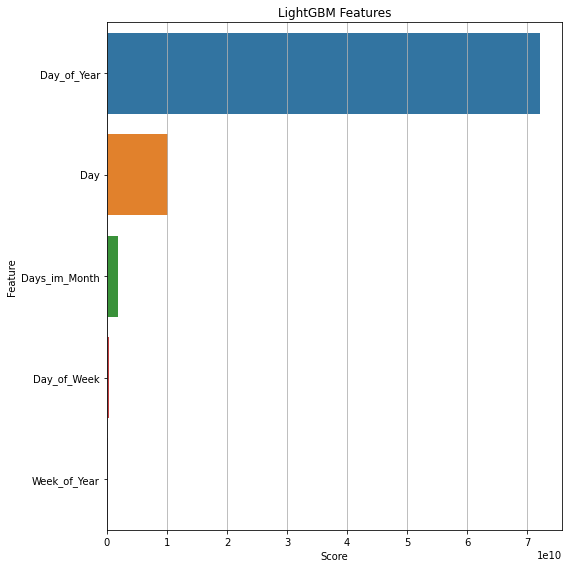

,Score,Feature
0,7.213165e+10,Day_of_Year
1,1.024398e+10,Day
2,1.852658e+09,Days_im_Month
3,3.466549e+08,Day_of_Week
4,1.430520e+08,Week_of_Year


In [9]:
plot_feature_importance(model_cc, X_train)

In [10]:
evaluate_model(model_cc, X_train, y_cc_train, X_val, y_cc_val)

Training error; ('rmsle', 3.7465809415514975)
Validation error: ('rmsle', 0.4258028935557645)


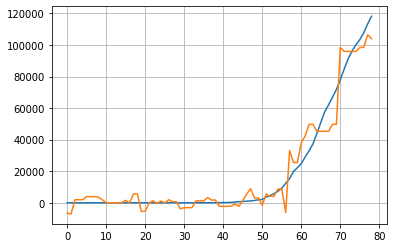

In [11]:
plt.plot(y_cc_train.values)
plt.plot(model_cc.predict(X_train))

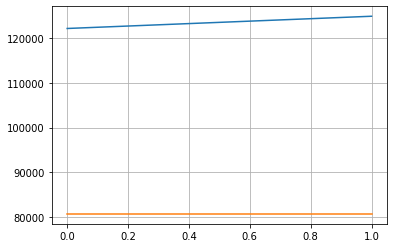

In [12]:
plt.plot(y_cc_val.values)
plt.plot(model_cc.predict(X_val))

# Modeling for all country

In [0]:
submission = pd.DataFrame(columns = submission.columns)

In [0]:
for country in train['Country_Region'].unique():
  print('start modeling for ', country, '...')
  provinces = train[train['Country_Region'] == country]['Province_State'].unique()
  for province in provinces:
    country_df = train[(train['Country_Region'] == country) & (train['Province_State'] == province)]
    X_train, y_cc_train, y_fa_train, X_val, y_cc_val, y_fa_val = train_val_split(country_df)
    model_cc = create_model(X_train, y_cc_train, X_val, y_cc_val)
    model_fa = create_model(X_train, y_fa_train, X_val, y_fa_val)

    test_df = test[(test['Country_Region'] == country) & (test['Province_State'] == province)]
    forcast_id = test_df['ForecastId'].values.tolist()

    X_test = test_df.drop(columns=test_col_to_delete)
    y_cc_hat = model_cc.predict(X_test)
    y_fa_hat = model_fa.predict(X_test)

    test_res = pd.DataFrame(columns=submission.columns)
    test_res['ForecastId'] = forcast_id
    test_res['ConfirmedCases'] = y_cc_hat
    test_res['Fatalities'] = y_fa_hat
    submission = submission.append(test_res)


start modeling for  Afghanistan ...
start modeling for  Albania ...
start modeling for  Algeria ...
start modeling for  Andorra ...
start modeling for  Angola ...
start modeling for  Antigua and Barbuda ...
start modeling for  Argentina ...
start modeling for  Armenia ...
start modeling for  Australia ...
start modeling for  Austria ...
start modeling for  Azerbaijan ...
start modeling for  Bahamas ...
start modeling for  Bahrain ...
start modeling for  Bangladesh ...
start modeling for  Barbados ...
start modeling for  Belarus ...
start modeling for  Belgium ...
start modeling for  Belize ...
start modeling for  Benin ...
start modeling for  Bhutan ...
start modeling for  Bolivia ...
start modeling for  Bosnia and Herzegovina ...
start modeling for  Botswana ...
start modeling for  Brazil ...
start modeling for  Brunei ...
start modeling for  Bulgaria ...
start modeling for  Burkina Faso ...
start modeling for  Burma ...
start modeling for  Burundi ...
start modeling for  Cabo Verde .

In [0]:
g = submission.copy()

In [0]:
for col in ['ConfirmedCases', 'Fatalities']:
    submission.loc[submission[col] < 0, col] = 0
submission

,ForecastId,ConfirmedCases,Fatalities
0,1,303.064845,7.647754
1,2,304.268222,7.412209
2,3,311.731701,7.412209
3,4,311.731701,7.412209
4,5,352.578238,9.464690
...,...,...,...
38,13455,5.372519,0.866422
39,13456,6.163383,1.193220
40,13457,6.163383,1.193220
41,13458,5.543923,1.163215


In [0]:
import json
submission_name = 'lgbm_9.4' 
access_token = {"username":"basselkassem","key":"8d90cbc0a49227baee35b1291c233f2f"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(access_token, file)
!pip install -q kaggle
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
submission.to_csv(submission_name + '.csv', index = 0)
!kaggle competitions submit -c covid19-global-forecasting-week-4 -f {submission_name}.csv -m "Message"

100% 515k/515k [00:01<00:00, 451kB/s]
403 - This competition only allows kernel submissions.


# Auto Regressor Intergrated Moving average

## Define function

In [0]:
def get_country(df, country, province):
    country_df = df[(df['Country_Region'] == country) & (df['Province_State'] == province)]
    country_df = country_df.set_index(keys = 'Date')
    return country_df
def rmsle(y, y_hat):
    y_hat = y_hat.clip(0)
    res = np.sqrt(mean_squared_log_error(y, y_hat))
    return res

def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.8)
    train, val = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(val)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(val[t])
    error = rmsle(val, np.array(predictions))
    return error

def get_arima_order(dataset, p_values, d_values, q_values, target):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmsle = evaluate_arima_model(dataset, order)
                    if rmsle < best_score:
                        best_score, best_cfg = rmsle, order
                except:
                    continue
    print('>>>', target, 'Best ARIMA%s RMSLE = %.3f' % (best_cfg, best_score))
    return best_cfg

In [0]:
p_values = [0, 1, 2, 3]
d_values = range(0, 2)
q_values = range(0, 2)
def model_per_country(country, province, show_plots = False):
    country_df = get_country(train, country, province)
    country_df_test = get_country(test, country, province)

    arima_order_cc = get_arima_order(country_df['ConfirmedCases'].values, p_values, d_values, q_values, 'ConfirmedCases')
    model_cc = ARIMA(country_df.ConfirmedCases, order = arima_order_cc, freq = 'D')
    fitted_model_cc = model_cc.fit(disp = 0)

    arima_order_fa = get_arima_order(country_df['Fatalities'].values, p_values, d_values, q_values, 'Fatalities')
    model_fa = ARIMA(country_df['Fatalities'], order = arima_order_fa, freq = 'D')
    fitted_model_fa = model_fa.fit(disp = 0)
   
    if show_plots:
        fitted_model_cc.plot_predict(arima_order_cc[1], len(country_df) + 90)
        fitted_model_fa.plot_predict(arima_order_fa[1], len(country_df) + 90)
        plt.show()
    return predict_res
    

## Syria

>>> ConfirmedCases Best ARIMA(0, 1, 0) RMSLE = 0.175
>>> Fatalities Best ARIMA(0, 1, 0) RMSLE = 0.194


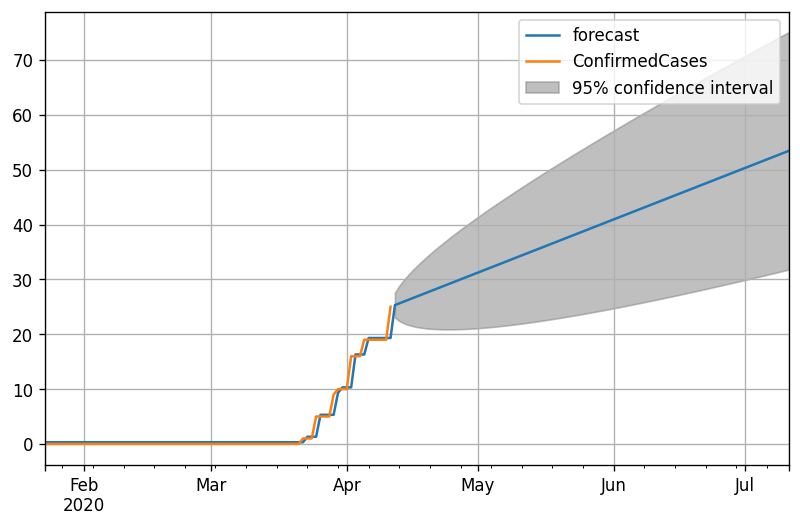

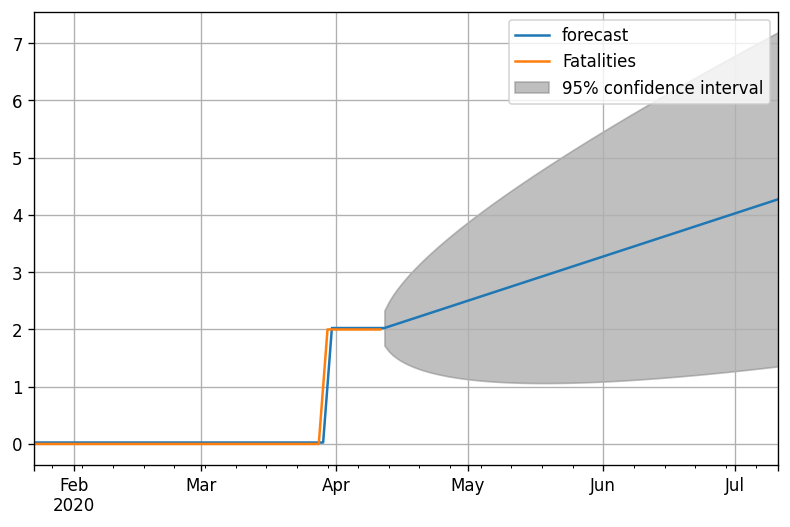

CPU times: user 11.9 s, sys: 14 ms, total: 11.9 s
Wall time: 12 s


In [25]:
%%time
show_plots = True
country = 'Syria'
province = '_PROVINCE_' + country
predict_res = model_per_country(country, province, True)

## Germany

>>> ConfirmedCases Best ARIMA(1, 1, 0) RMSLE = 0.019
>>> Fatalities Best ARIMA(2, 1, 0) RMSLE = 0.035


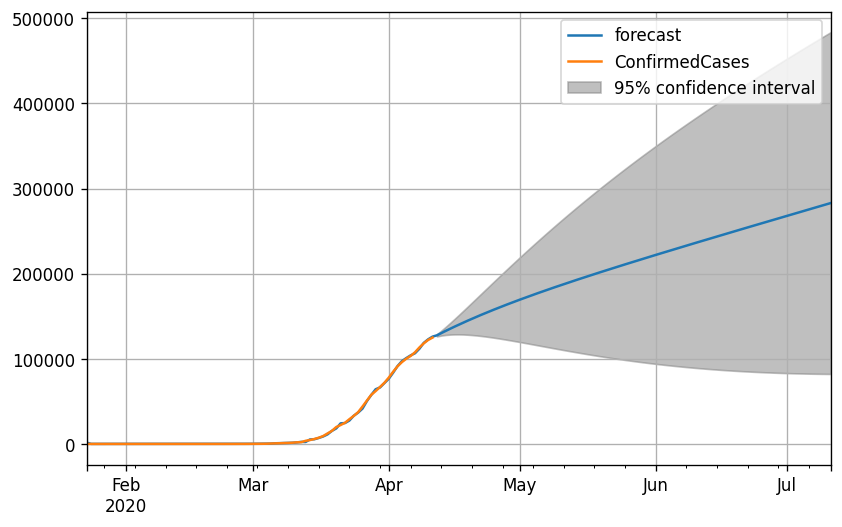

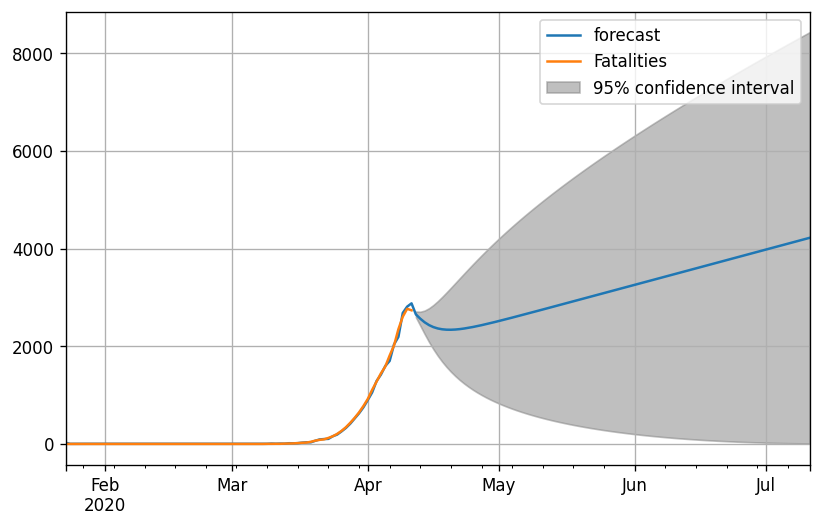

CPU times: user 18 s, sys: 17.9 ms, total: 18 s
Wall time: 18 s


In [26]:
%%time
show_plots = True
country = 'Germany'
province = '_PROVINCE_' + country
predict_res = model_per_country(country, province, True)

## The whole world

In [27]:
df = train.groupby(by = 'Date').sum()
df = df.drop(columns = 'Id')
df.head()

,ConfirmedCases,Fatalities
Date,,
2020-01-22,554.0,17.0
2020-01-23,653.0,18.0
2020-01-24,939.0,26.0
2020-01-25,1432.0,42.0
2020-01-26,2113.0,56.0


>>> ConfirmedCases Best ARIMA(1, 1, 0) RMSLE = 0.011
>>> Fatalities Best ARIMA(1, 1, 0) RMSLE = 0.013


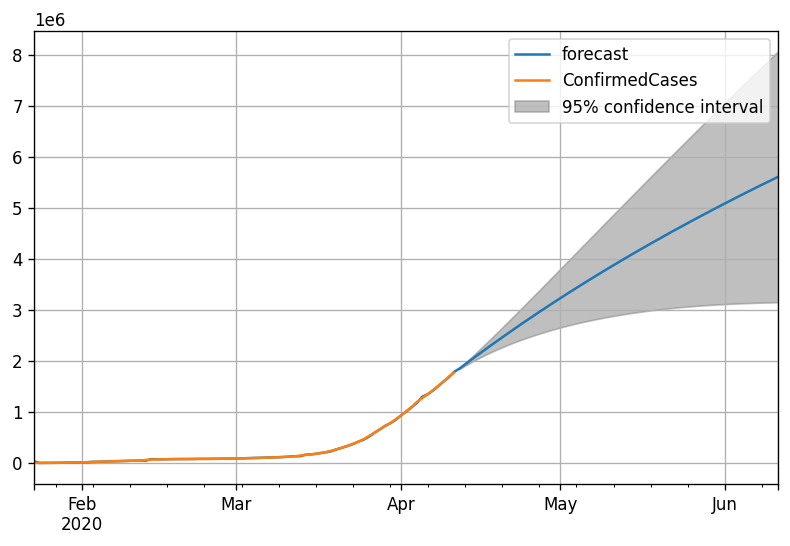

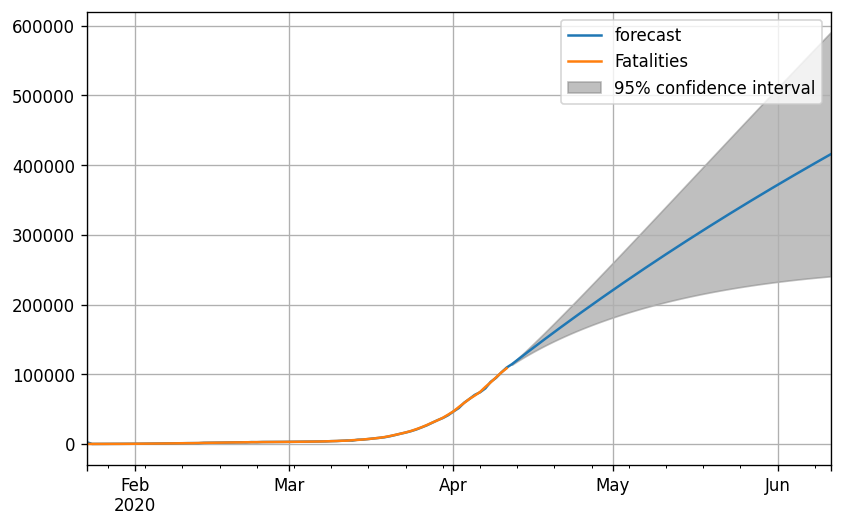

In [28]:
arima_order_cc = get_arima_order(df['ConfirmedCases'].values, p_values, d_values, q_values, 'ConfirmedCases')
model_cc = ARIMA(df.ConfirmedCases, order = arima_order_cc, freq = 'D')
fitted_model_cc = model_cc.fit(disp = 0)

arima_order_fa = get_arima_order(df['Fatalities'].values, p_values, d_values, q_values, 'Fatalities')
model_fa = ARIMA(df['Fatalities'], order = arima_order_fa, freq = 'D')
fitted_model_fa = model_fa.fit(disp = 0)
fitted_model_cc.plot_predict(arima_order_cc[1], len(df) + 60)
fitted_model_fa.plot_predict(arima_order_fa[1], len(df) + 60)
plt.show()

In [0]:
y